In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [3]:
DatabaseDF = pd.read_csv("../CleanedDataset.csv")

## Definition

The edgeworth box diagram is a tool used in economics that plots the indifference curves of two groups so that an efficient trade between the two can be found.

An indifference curve is a plot in economics where given an x axis of the quantity of a certain good, and a y axis of a quantity of a different good, curve is drawn connecting all points of (x,y) pairs (meaning they have x of one good and y of the other) that have the same utility. Since a certain good may provide more utility than another this line is not always 1:1, and since there could be a margin of decreasing return (the more you get of one quantity the benefit from earning one more may decrease) meaning this line may be curved. It is called an indifference curve since by definition the user does not care which pair of coordinates on the line it has since they all provide the same utility.

By plotting two indifference curves with origns on opposite corners, an edgworth box is able to determine where they cross at a point called the Pareto Optimality. At this point the two parties have exchanged their resources in such a way that they both purely benefited from the trade. 

Our goal is to determine if there is a relationship between two variables that fits this idea of indifference curves for wells, and if there would ever be a situation where an exchange between wells could occurr how an edgworth box might facilitate that.

## Creating oil well indifference curves

My First hypothesis is that stage completion type and quantity may follow this model of indifference curves, where perhaps buidling more of one type than another could change how much oil is generated. Firstly I want to determine if there is a link between number of stages and oil production, and idealy this should show that more stages always means more oil

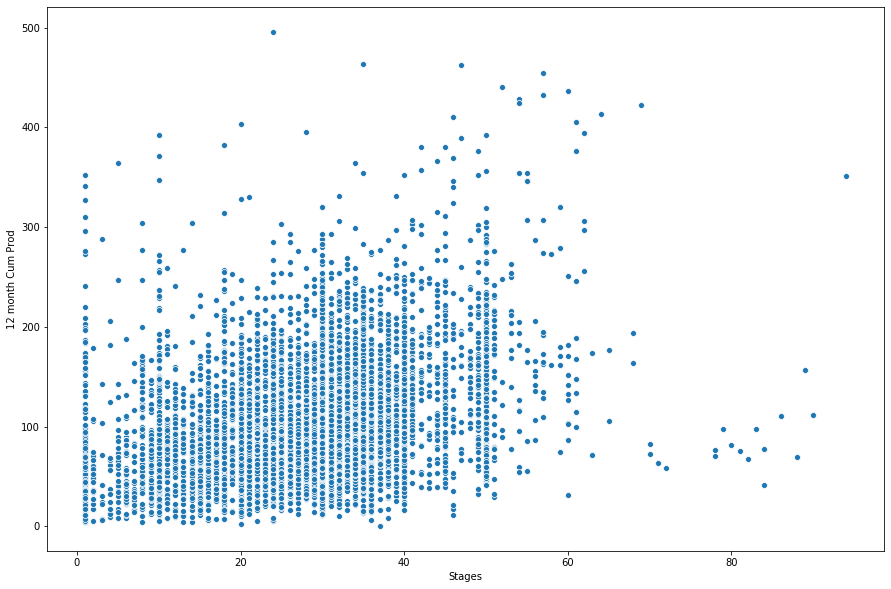

In [4]:
plt.subplots(figsize = (15,10))
sns.scatterplot(x = 'Stages', y = '12 month Cum Prod', data = DatabaseDF)

Whith the exception of some outlier points at the end of the list this seems to show that more stages increases oil production, however it appears to be an exponential curve at the very least with there being a greater increase as the stages increase. I will firstly chop off the outliers above 70 stages in order to look at just the exponential data

In [5]:
DatabaseDF = DatabaseDF[DatabaseDF['Stages'] < 70]

In [6]:
def plotfunc(x, a, b, c):
    return a * (b**x) + c

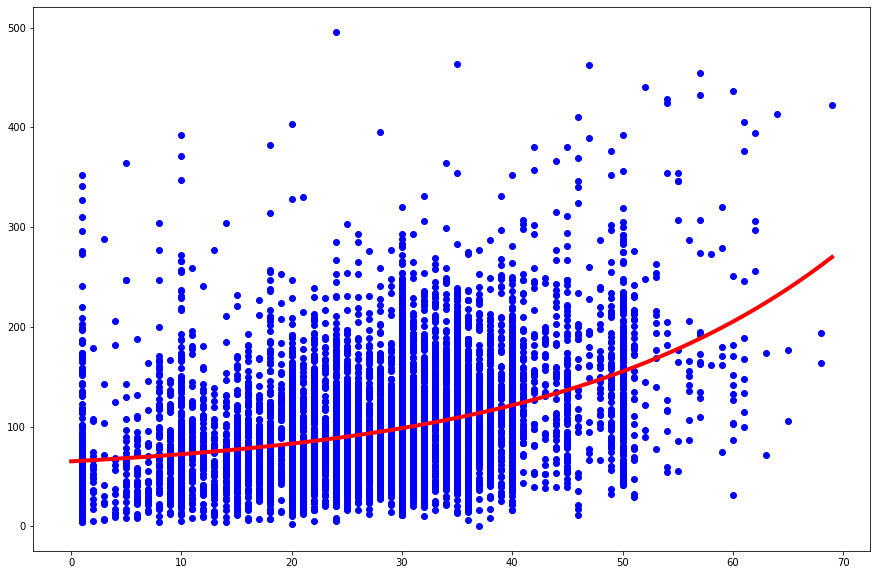

' This model is really good in terms of the transition of stages of the cumulative production '

In [7]:
from scipy.optimize import curve_fit

x = DatabaseDF['Stages']
y = DatabaseDF['12 month Cum Prod']

plt.subplots(figsize = (15,10))
plt.plot(x,y, 'bo')

popt, pcov = curve_fit(plotfunc,x,y)

x_plot = np.linspace(0, x.max(), x.max() + 1)

plt.plot(x_plot,plotfunc(x_plot, popt[0], popt[1], popt[2]), 'r-',
            linewidth = 4)

plt.show()

""" This model is really good in terms of the transition of stages of the cumulative production """

**TODO:** Determine the error behind using a model like this 



Now that this has been plotted for stages as a whole and we generally can see that the curve follows the correct trends, I will try to do the same for two types of stages in particular, Sleeves and P&P

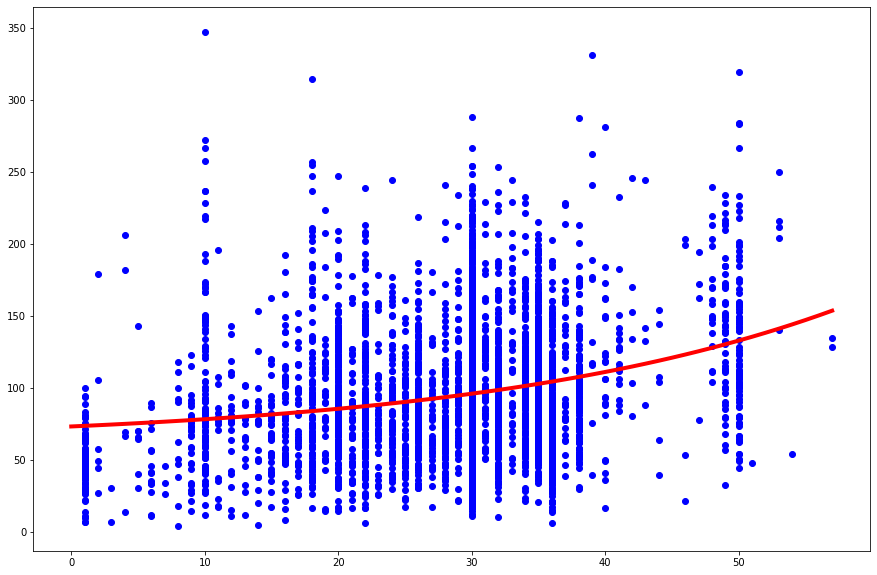

In [8]:
""" For error I would recommend the mean absolute error as it is better for an interpretation standpoint as MSE is more for large errors within the data"""


x_sleeves = DatabaseDF[DatabaseDF['Completion Type'] == 'Sleeves' ]['Stages']
y_sleeves = DatabaseDF[DatabaseDF['Completion Type'] == 'Sleeves' ]['12 month Cum Prod']

plt.subplots(figsize = (15,10))
plt.plot(x_sleeves,y_sleeves, 'bo')

popt_sleeves, pcov_sleeves = curve_fit(plotfunc,x_sleeves,y_sleeves)

x_plot_sleeves = np.linspace(0, x_sleeves.max(), x_sleeves.max() + 1)

plt.plot(x_plot_sleeves,plotfunc(x_plot_sleeves, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2]), 'r-',
            linewidth = 4)

plt.show()

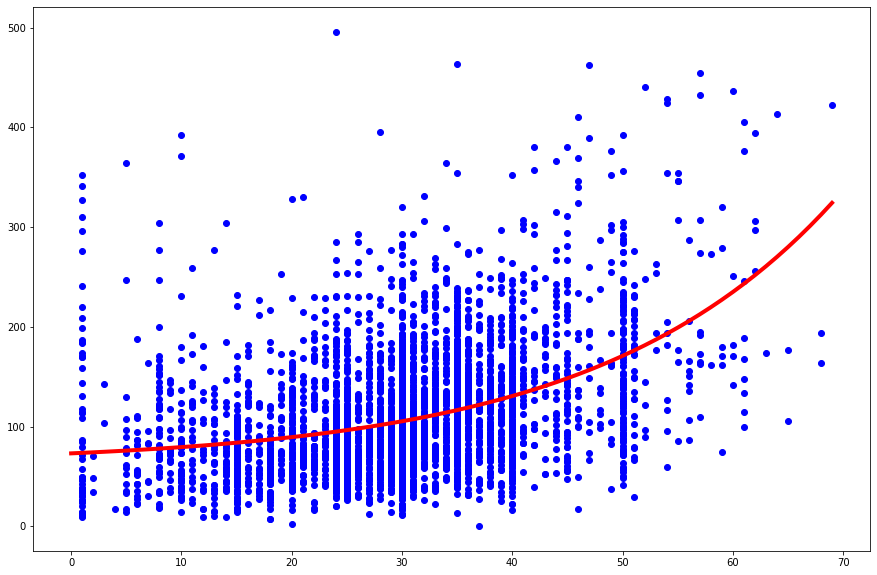

In [9]:
x_PandP = DatabaseDF[DatabaseDF['Completion Type'] == 'P & P' ]['Stages']
y_PandP = DatabaseDF[DatabaseDF['Completion Type'] == 'P & P' ]['12 month Cum Prod']

plt.subplots(figsize = (15,10))
plt.plot(x_PandP,y_PandP, 'bo')

popt_PandP, pcov_PandP = curve_fit(plotfunc,x_PandP,y_PandP)

x_plot_PandP = np.linspace(0, x_PandP.max(), x_PandP.max() + 1)

plt.plot(x_plot_PandP,plotfunc(x_plot_PandP, popt_PandP[0], popt_PandP[1], popt_PandP[2]), 'r-',
            linewidth = 4)

plt.show()

In order to to see if this is an accurate way of measuring oil production, I will now compare how our predictions stack up with the available data of oil wells that mix Sleeves and P&P completions. The only issue however is in how we will deal with the constant C used in both equations. The constant is supposed to account for the base production that drilling at all should yield, with 0 stages. simply doing predict(sleeve) + predict(p&p) = predict(combined) will not work since it takes int account both constants. I will try out a couple options below to see which is closest in predicting the right values

In [9]:
mixedDF = DatabaseDF[DatabaseDF['Completion Type'] == 'Sleeves and P & P'].fillna(0)

mixedDF = mixedDF[['Stages', 'Sleeves', 'P&P', '12 month Cum Prod']]

def estimateNaive(sleeves, pandp):
    pandpEst = plotfunc(pandp, popt_PandP[0], popt_PandP[1], popt_PandP[2])
    sleeveEst = plotfunc(sleeves, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2])

    return pandpEst + sleeveEst

def estimateNoConst(sleeves, pandp):
    pandpEst = plotfunc(pandp, popt_PandP[0], popt_PandP[1], 0)
    sleeveEst = plotfunc(sleeves, popt_sleeves[0], popt_sleeves[1], 0)

    return pandpEst + sleeveEst

def estimateMixed(sleeves, pandp):
    total = sleeves + pandp
    pandpEst = plotfunc(pandp, popt_PandP[0], popt_PandP[1], popt_PandP[2] * (pandp/total))
    sleeveEst = plotfunc(sleeves, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2] * (sleeves/total))

    return pandpEst + sleeveEst

In [10]:
naiveError = 0
NCError = 0
MXError = 0

counter = 0;

for index, row in mixedDF.iterrows():
    counter += 1;
    
    Actual = row['12 month Cum Prod']
    Naive = estimateNaive(row['Sleeves'], row['P&P'])
    NC = estimateNoConst(row['Sleeves'], row['P&P'])
    MX = estimateMixed(row['Sleeves'], row['P&P'])

    naiveError += abs(Actual - Naive)
    NCError += abs(Actual - NC)
    MXError = abs(Actual - MX)

print("Total Checked: ", counter)
print("Naive Error: ", naiveError)
print("No Constant Error: ", NCError)
print("Mixed Error: ", MXError)
""" Would suggest looking into the other types of errors as well such as MAE and MSE""" 

Total Checked:  360
Naive Error:  25552.9423395637
No Constant Error:  21999.942017188132
Mixed Error:  41.601204202064366


By far and away the most accurate form of prediction was the estimateMixed formula which took into account the percentage of stages that were of the corresponding type. It also way outperformed even our initial expecxtations, showing that perhaps this is a relatively accurate way of predicting oil production

In order to create the indifference curves, I will use a contour plot to showcase how increasing Sleeve and P&P completions affects total oil production 

In [11]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

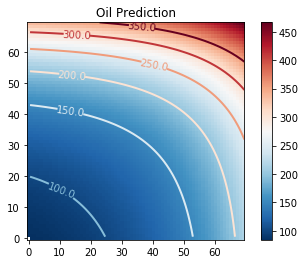

In [12]:
sleeves_grid = np.arange(0, 70, 1)
pandp_grid = np.arange(0,70,1)

Sleeves, PandP = meshgrid(sleeves_grid,pandp_grid)
oilProduction = estimateMixed(Sleeves,PandP)

im = imshow(oilProduction, cmap = cm.RdBu_r, origin = 'lower')

title('Oil Prediction')

cset = contour(oilProduction, np.arange(0,400,50), linewidths = 2, cmap=cm.RdBu_r, origin = 'lower')
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

colorbar(im)

show()

These are our indifference curves, any point along those contours has the same prediction of oil production based on the x axis of sleeves and y axis of p&p completions. With these in hand we should be able to create a boxworth diagram that attempts to solve for an optimal exchange between wells

## Implementing the Boxworth Diagram

The main issue with using an edgeworth box is that it attempts to figure out the optimal exchange for two groups who trade a limited resource, in such a way that they both maintain their same level of utility. While this isn't exactly how oil production works I think it would be interesting to see how given two existing wells and theri already established distribution of completion types, they could perhaps be exchanged such that they both benefit

In [13]:
import pyEdgeworthBox as eb

In [14]:
EB = eb.EdgeBox( u1 = estimateMixed, u2 = estimateMixed,
                IE1 = [20,20], IE2 = [40,40])

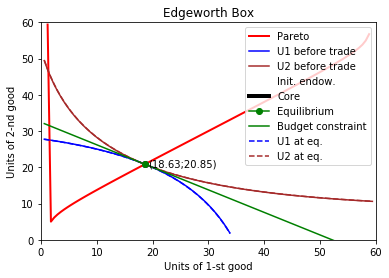

In [15]:
EB.plot()

While this package is useful I think it is too barebones as a good edgeworth box diagram, and would like to create one myself

first challenge comes in trying to determine the best way to create two indifference curves drawn on the same graph. The previous indifference curves were done using the contour feature, however I think in order to create a model whre I can check overlaping points I will need to determine a function to calulcate y from x on a graph, or in other words given a number of sleeves and 12 month cum prod calculate how many p&p sleeves would be requred to achieve that.

In [16]:
import math

In [17]:
testfunc = lambda x,z: (math.log(-(plotfunc(x, popt_sleeves[0], popt_sleeves[1], popt_sleeves[2]) - z)/(popt_PandP[0]))) / (math.log(popt_PandP[1]))

for x in range(1,100):
    for y in range(1,100):
        z = estimateMixed(x,y)

        if (math.floor(testfunc(x,z)) != y):
            print("x-",x)
            print("error: y-",y,"|func-",testfunc(x,z) )

x- 1
error: y- 4 |func- 5.006455356642956
x- 1
error: y- 5 |func- 6.000955511092161


In [18]:
z = estimateMixed(32,0)
print(z)

109.14152568309517


In [19]:
for x in range(0,33):
    y = testfunc(x,z)
    print("x: ", x, " | y: ", y)
    print("z: ", estimateMixed(x,y))

x:  0  | y:  26.254158171453653
z:  109.90714298483577
x:  1  | y:  25.99884828216763
z:  109.87878557885537
x:  2  | y:  25.730766341496523
z:  109.85192508769495
x:  3  | y:  25.449101157020174
z:  109.82640750245464
x:  4  | y:  25.152971758709292
z:  109.80209471626442
x:  5  | y:  24.84141930990634
z:  109.77886200500208
x:  6  | y:  24.513397809190437
z:  109.75659587634365
x:  7  | y:  24.167763359369218
z:  109.73519220831099
x:  8  | y:  23.803261729989508
z:  109.71455461242525
x:  9  | y:  23.418513876796155
z:  109.69459296660077
x:  10  | y:  23.011999001483282
z:  109.67522206974482
x:  11  | y:  22.58203463245053
z:  109.656360374094
x:  12  | y:  22.126753074696904
z:  109.63792875279977
x:  13  | y:  21.644073404251415
z:  109.61984925910991
x:  14  | y:  21.131667955431382
z:  109.60204382933976
x:  15  | y:  20.586921947688946
z:  109.58443287399814
x:  16  | y:  20.00688449424091
z:  109.56693368875496
x:  17  | y:  19.388208685694334
z:  109.54945859751095
x:  18  

While I am not thrilled about the results of this as there seems to be some error still, I think it should suffice to move on and at least create a proof of concept

In [20]:
PandPCalc = testfunc

(0, 60)

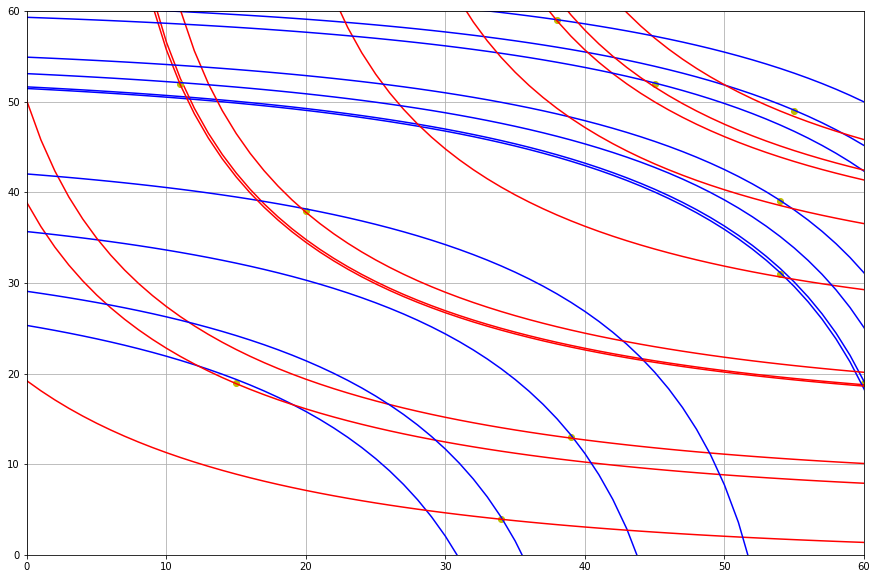

In [21]:
from random import randint

plt.subplots(figsize = (15,10))

totalSleeves = 60
totalPandP = 60

initialList = []

for i in range(1,12):
    initialList.append([randint(1,60),randint(1,60)])

##initialList = [[20,20],[40,40],[15,30],[24,12]]

for x_Initial in initialList:

    y_Initial = [totalSleeves - x_Initial[0], totalPandP - x_Initial[1]]

    ## person X

    plt.plot(x_Initial[0],x_Initial[1], 'yo')

    x_z = estimateMixed(x_Initial[0], x_Initial[1])

    x_cords = []
    x_res = []

    done = False
    x_counter = 0

    while not done:
        x_current_res = PandPCalc(x_counter, x_z)

        if (x_current_res < 0):
            done = True

        x_cords.append(x_counter)
        x_res.append(x_current_res)

        x_counter += 1

    plt.plot(x_cords, x_res, 'b-')

    ## person Y

    y_z = estimateMixed(y_Initial[0], y_Initial[1])

    y_cords = []
    y_res = []

    done = False
    y_counter = 0

    while not done:
        y_current_res = PandPCalc(y_counter,y_z)

        if(y_current_res < 0):
            done = True

        y_cords.append(totalSleeves - y_counter)
        y_res.append(totalPandP - y_current_res)

        y_counter += 1

    plt.plot(y_cords, y_res, 'r-')



plt.grid()

plt.xlim(0,totalSleeves)
plt.ylim(0,totalPandP)

After completing this I have come to realize something, since we have two variables where there is an exponential increase in utility output It is actually optimal to fully specialize into only one completion type rather than mixing stages. I will test this hypothesis to be sure. However that does not meant this is entirely useless, there are a lot of details that go into completion types chosen and perhaps there could be only a finite ammount of states that you can choose from, in which case it would be handy to know if there is an optimal one

## Extra testing: specializing in one completion type yields optimal results

In [22]:
DatabaseDF = pd.read_csv("../CleanedDataset.csv")

In [23]:
counter = 0

hits = 0

for index, row in mixedDF.iterrows():
    prod =  row['12 month Cum Prod']

    sleeveDF = DatabaseDF[(DatabaseDF['Completion Type'] == 'Sleeves') & (DatabaseDF['Stages'] == row['Stages'])]
    pandpDF = DatabaseDF[(DatabaseDF['Completion Type'] == 'P & P') & (DatabaseDF['Stages'] == row['Stages'])]

    if (len(sleeveDF) > 0 and prod > sleeveDF['12 month Cum Prod'].mean()):
        hits += 1
    elif (len(pandpDF) > 0 and prod > pandpDF['12 month Cum Prod'].mean()):
        hits += 1

    if (len(sleeveDF) > 0 or len(pandpDF) > 0):
        counter += 1

print("Hit Percent: " , (hits/counter))

Hit Percent:  0.44722222222222224


This tells us that about 44.7% of the time not specializing actually yielded higher results, however I think it's telling that the majority of the time specalizaiton was the correct choice. Perhaps we should analyze why those 44.7% hit and what made them so

# Model Definition: Pareto Chart

A Pareto Chart is a combination of a bar graph and line graph used in Economics and Business that shows the influence that various (independent) categorical variables have on a continuous (dependent) variable in the dataset. The bars are ordered such that the most frequent or prominent independent variable is on the left and the least significant variable is on the right. The line graph represent the cumulative percentages of the dependent variable and how each independent variable contributes to that percentage.

This model is more of a tool that helps analyze different features and which of them should be prioritized; it is not used for estimating a value. Pareto Charts are good if you want to narrow down the features to find the most frequent/prominent  ones, so that you can focus on the ones that are the most impactful for the final product or for a certain variable.

A Pareto Chart can be applied to oil because it can be help us narrow down certain variables by seeing which ones affect cumulative oil production the most. From there, we can decide how to distribute resources in order to maximize production. # Model Definition: Pareto Chart

A Pareto Chart is a combination of a bar graph and line graph used in Economics and Business that shows the influence that various (independent) categorical variables have on a continuous (dependent) variable in the dataset. The bars are ordered such that the most frequent or prominent independent variable is on the left and the least significant variable is on the right. The line graph represent the cumulative percentages of the dependent variable and how each independent variable contributes to that percentage.

This model is more of a tool that helps analyze different features and which of them should be prioritized; it is not used for estimating a value. Pareto Charts are good if you want to narrow down the features to find the most frequent/prominent  ones, so that you can focus on the ones that are the most impactful for the final product or for a certain variable.

A Pareto Chart can be applied to oil because it can be help us narrow down certain variables by seeing which ones affect cumulative oil production the most. From there, we can decide how to distribute resources in order to maximize production. 

# Imputed Datasets

## Categorical Variables

In [7]:
#Imputed Dataset with categorical variables
ImputedDS = pd.read_csv("../DatasetIIandCI.csv")
ImputedDS.head()

Unnamed: 0  Lateral Length     Stages  Township   Range  Section  \
0           0          5114.0  30.000000      141.0   99.0     10.0   
1           1          5181.0  -1.722697      142.0   99.0     16.0   
2           2          4780.0  15.000000      142.0   99.0     24.0   
3           3         10654.0   1.000000      142.0   99.0      1.0   
4           4          5209.0   1.000000      142.0   99.0     35.0   

   Total Prop, lbs  Fluid, bbls  Best1 Mo BOPD  Best3 Mo BOPD  ...  \
0              0.0      16079.0     141.518738     127.690116  ...   
1         418000.0       7269.0     197.764629     127.832566  ...   
2         568407.0       8279.0      52.071006      44.334867  ...   
3         845000.0       9342.0     136.752137     120.764848  ...   
4         297366.0       4523.0     249.178172     227.580539  ...   

   Best12 Mo BOPD   Latitude   Longitude  SPACING_CAPPED  12 month Cum Prod  \
0       88.275258  47.051150 -103.214580           660.0              33.55   
1       72.019505  47.111368 -103.225059           660.0              27.62   
2       28.566732  47.097032 -103.160910           660.0              11.19   
3       75.882095  47.140248 -103.178391           660.0              27.85   
4      140.033969  47.080872 -103.181300           660.0              50.88   

   Year Drilled    Operator  Formation Fluid Type from DI Completion Type  
0        2006.0  Operator 1        MBH    SLICKWATER (HC)           P & P  
1        2005.0  Operator 2        MBH   CROSSLINKED (HC)           P & P  
2        2006.0  Operator 2        MBH   CROSSLINKED (HC)              OH  
3        2007.0  Operator 1        MBH    SLICKWATER (HC)           P & P  
4        2006.0  Operator 2        MBH   CROSSLINKED (HC)              OH  

[5 rows x 22 columns]

## Quantitative Variables

In [9]:
#Imputed Dataset with quantitative variables
MICE_DF= pd.read_csv("../IterativeImputeDS.csv")
MICE_DF.head()

Unnamed: 0  Lateral Length     Stages  Township   Range  Section  \
0           0          5114.0  30.000000      141.0   99.0     10.0   
1           1          5181.0  -1.722697      142.0   99.0     16.0   
2           2          4780.0  15.000000      142.0   99.0     24.0   
3           3         10654.0   1.000000      142.0   99.0      1.0   
4           4          5209.0   1.000000      142.0   99.0     35.0   

   Total Prop, lbs  Fluid, bbls  Best1 Mo BOPD  Best3 Mo BOPD  Best6 Mo BOPD  \
0              0.0      16079.0     141.518738     127.690116     110.009862   
1         418000.0       7269.0     197.764629     127.832566      99.128863   
2         568407.0       8279.0      52.071006      44.334867      36.905545   
3         845000.0       9342.0     136.752137     120.764848      99.172693   
4         297366.0       4523.0     249.178172     227.580539     189.869603   

   Best9 Mo BOPD  Best12 Mo BOPD   Latitude   Longitude  SPACING_CAPPED  \
0      97.351888       88.275258  47.051150 -103.214580           660.0   
1      83.694938       72.019505  47.111368 -103.225059           660.0   
2      31.766382       28.566732  47.097032 -103.160910           660.0   
3      86.675433       75.882095  47.140248 -103.178391           660.0   
4     163.163854      140.033969  47.080872 -103.181300           660.0   

   12 month Cum Prod  Year Drilled  
0              33.55        2006.0  
1              27.62        2005.0  
2              11.19        2006.0  
3              27.85        2007.0  
4              50.88        2006.0

# Plotting Formation Type against Cumulative Oil Production.

In [13]:
#Function to plot pareto chart
def pareto_plot(x , counts, xlabel = "x-axis", ylabel = 'Counts', show_pct_y=False, pct_format='{0:.0%}'):

    if (type(x) != 'str'):
        x = x.astype(str)

    weights = counts/counts.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots(figsize = (15,10))
    ax1.bar(x, counts)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    plt.xticks(rotation = 25)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    plt.ylim(bottom = 0)
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if xlabel is not "x-axis":
        plt.title(xlabel + " Pareto Chart")
    
    plt.tight_layout()
    plt.show()

## Cleaned Data

In [14]:
#Calculate cumulative oil production for each formation type
FormationProd = DatabaseDF.groupby('Formation')['12 month Cum Prod'].sum().sort_values(ascending = False)

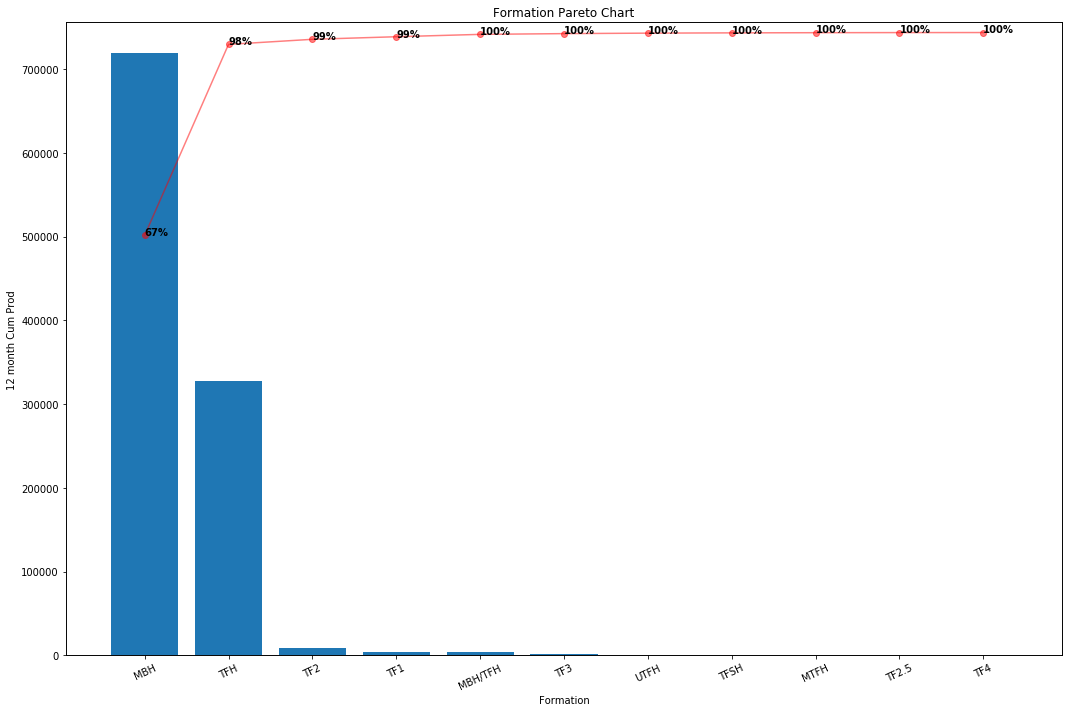

In [15]:
#Plot Pareto Chart of Formation Type versus Cumulative Production
pareto_plot(x = FormationProd.index, counts = FormationProd.values, xlabel = 'Formation', ylabel = '12 month Cum Prod')

## Imputed Data

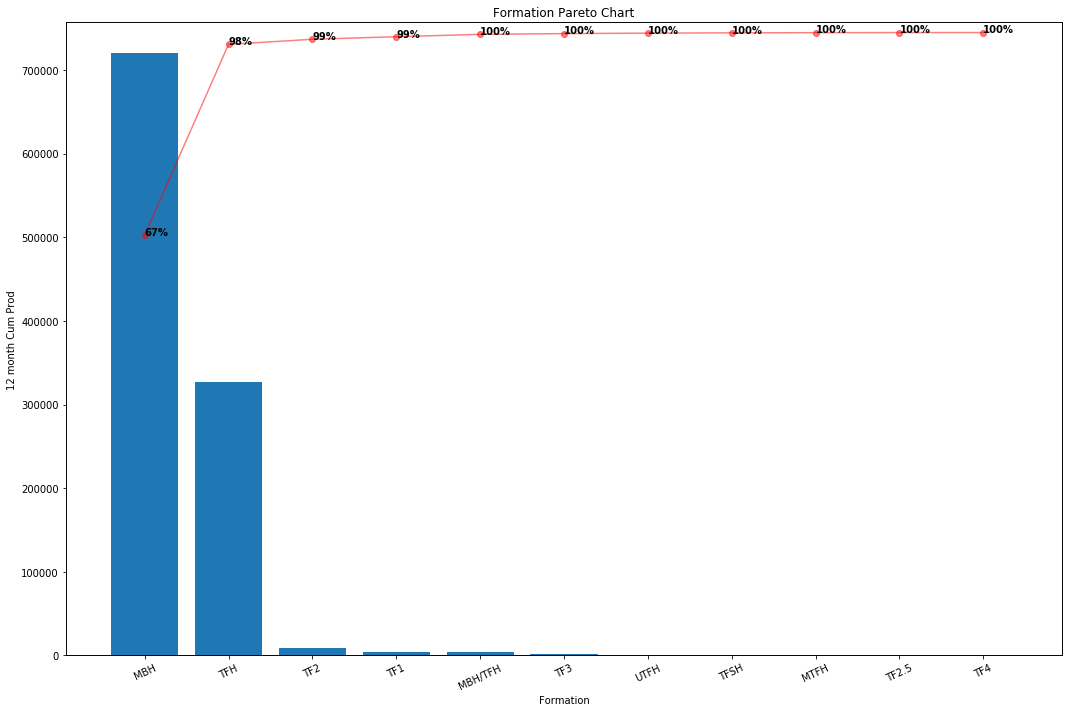

In [16]:
#Calculate cumulative oil production for each formation type
FormationProd = ImputedDS.groupby('Formation')['12 month Cum Prod'].sum().sort_values(ascending = False)

#Plot Pareto Chart of Formation Type versus Cumulative Production
pareto_plot(x = FormationProd.index, counts = FormationProd.values, xlabel = 'Formation', ylabel = '12 month Cum Prod')

The MBH and TFH formation types seem to be the most impactful on oil production in the dataset, where the MBH formation is associated with 67% of the cumulative production and TFH is associated with 31% of the cumulative production.

# Plotting Completion Type against Cumulative Oil Production.

## Cleaned Data

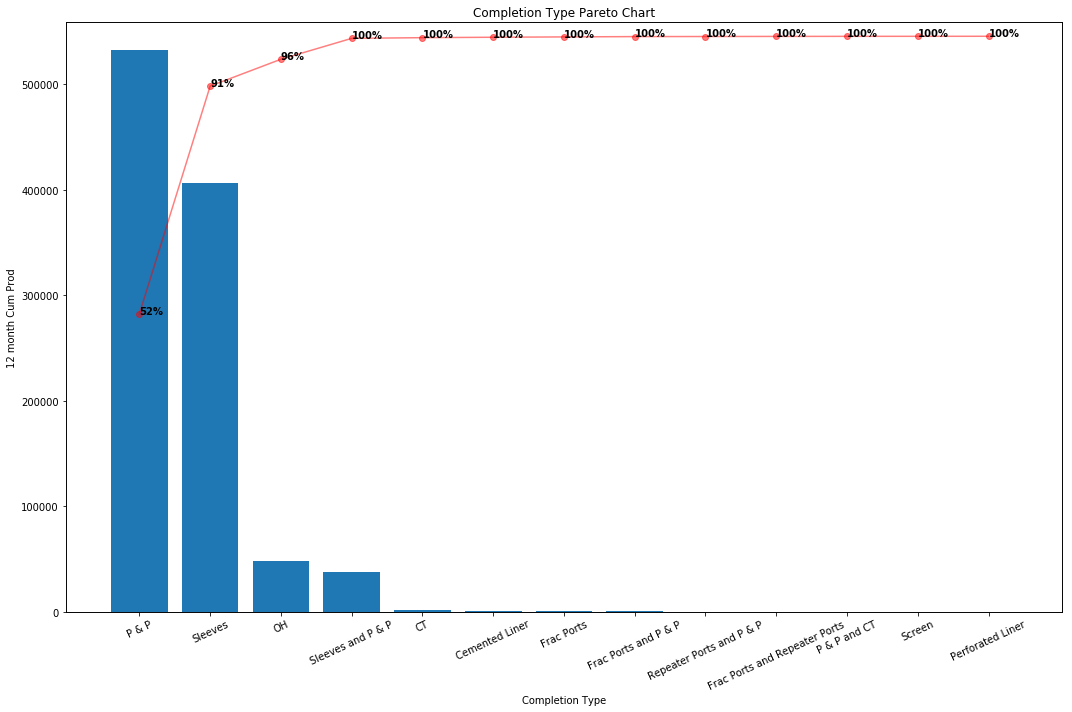

In [19]:
#Calculate cumulative oil production for each completion type
ComplTypeProd = DatabaseDF.groupby('Completion Type')['12 month Cum Prod'].sum().sort_values(ascending = False)

#Plot Pareto Chart of Completion Type versus Cumulative Production
pareto_plot(x = ComplTypeProd.index , counts = ComplTypeProd.values, xlabel = 'Completion Type', ylabel = '12 month Cum Prod')

## Imputed Data

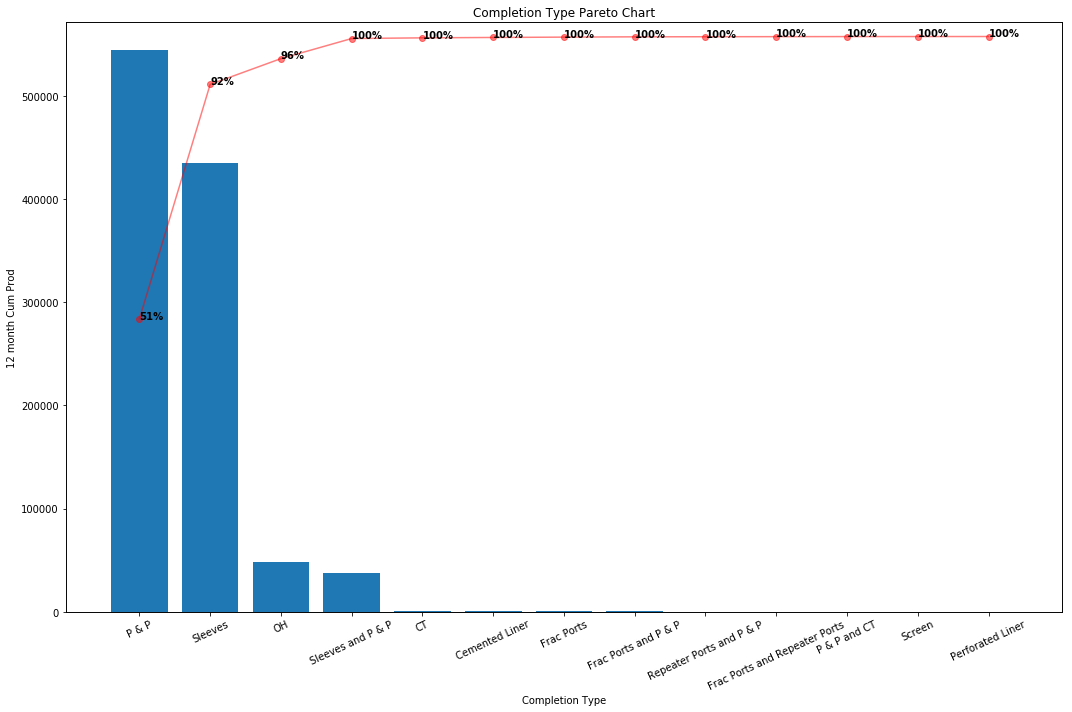

In [20]:
#Calculate cumulative oil production for each completion type
ComplTypeProd = ImputedDS.groupby('Completion Type')['12 month Cum Prod'].sum().sort_values(ascending = False)

#Plot Pareto Chart of Completion Type versus Cumulative Production
pareto_plot(x = ComplTypeProd.index , counts = ComplTypeProd.values, xlabel = 'Completion Type', ylabel = '12 month Cum Prod')

The P&P and Sleeves completion types seem to be the most impactful on the oil production in the dataset, where P&P is associated with around 50% of the cumulative production and Sleeves is associated with around 38% of the cumulative production.

# Plotting Fluid Type against Cumulative Oil Production.

## Cleaned Data

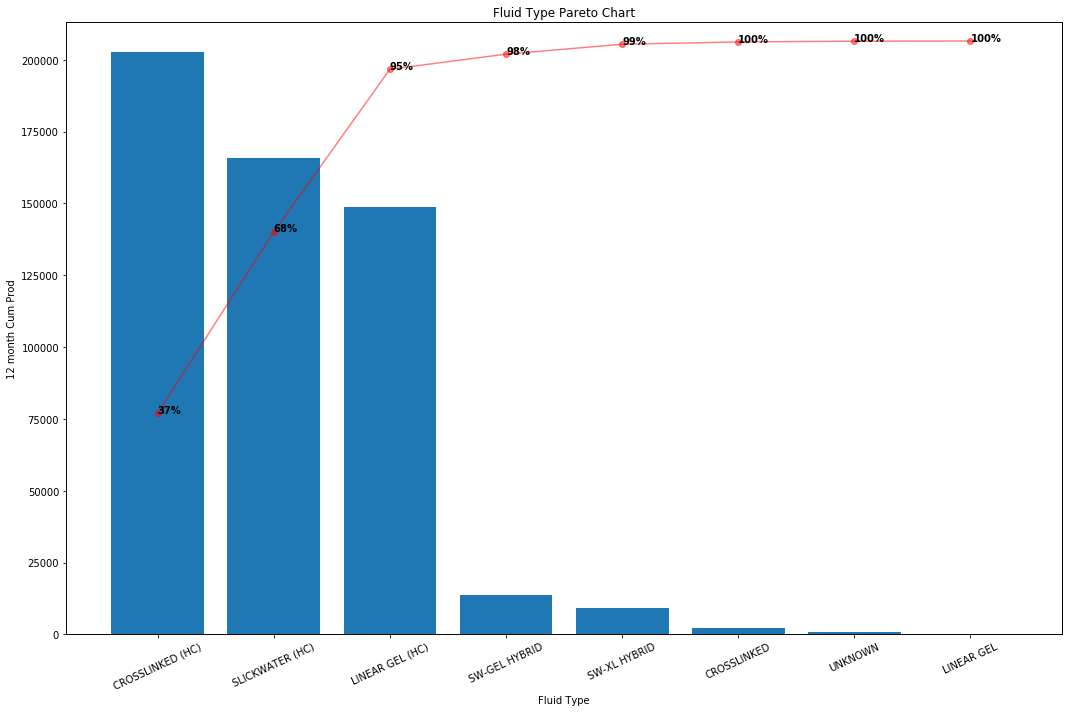

In [22]:
#Calculate cumulative oil production for each fluid type
FluidTypeProd = DatabaseDF.groupby('Fluid Type from DI')['12 month Cum Prod'].sum().sort_values(ascending = False)

#Plot Pareto Chart of Fluid Type versus Cumulative Production
pareto_plot(x = FluidTypeProd.index , counts = FluidTypeProd.values, xlabel = 'Fluid Type', ylabel = '12 month Cum Prod')

## Imputed Data

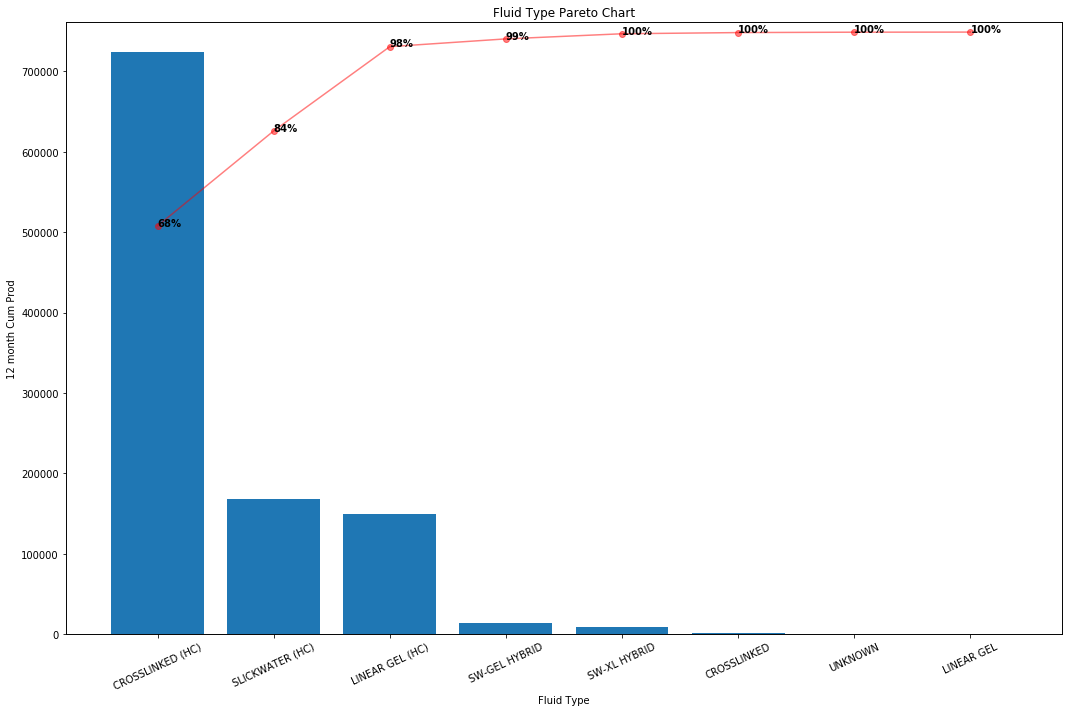

In [23]:
#Calculate cumulative oil production for each fluid type
FluidTypeProd = ImputedDS.groupby('Fluid Type from DI')['12 month Cum Prod'].sum().sort_values(ascending = False)
#Plot Pareto Chart of Fluid Type versus Cumulative Production
pareto_plot(x = FluidTypeProd.index , counts = FluidTypeProd.values, xlabel = 'Fluid Type', ylabel = '12 month Cum Prod')

After utilizing the imputed data, there is a significant distinction between the Fluid Types. The Crosslinked Fluid seems to be the one that is associated with a higher oil production, at around 68%. 

# Head-Tail Break Clustering Algorithm

In [25]:
#Function for head-tails break algorithm, to cluster and group data
def htb(data):
    """
    Applies the head/tail breaks algorithm to an array of data.
    Params
    ------
    data : list
        Array of data to apply ht-breaks
    Returns
    -------
    results : list 
        List of data representing break points
    """
    # test input
    assert data, "Input must not be empty."
    assert all(isinstance(datum, int) or isinstance(datum, float) for datum in data), "All input values must be numeric."

    results = []  # array of break points

    def htb_inner(data):
        """
        Inner ht breaks function for recursively computing the break points.
        """
        # Add mean to results
        data_length = float(len(data))
        data_mean = sum(data) / data_length
        results.append(data_mean)

        # Recursive call to get next break point
        head = [datum for datum in data if datum > data_mean]
        while len(head) > 1 and len(head) / data_length < 0.40:
            return htb_inner(head)

    htb_inner(data)

    return results#Function for head-tails break algorithm, to cluster and group data
def htb(data):
    """
    Applies the head/tail breaks algorithm to an array of data.
    Params
    ------
    data : list
        Array of data to apply ht-breaks
    Returns
    -------
    results : list 
        List of data representing break points
    """
    # test input
    assert data, "Input must not be empty."
    assert all(isinstance(datum, int) or isinstance(datum, float) for datum in data), "All input values must be numeric."

    results = []  # array of break points

    def htb_inner(data):
        """
        Inner ht breaks function for recursively computing the break points.
        """
        # Add mean to results
        data_length = float(len(data))
        data_mean = sum(data) / data_length
        results.append(data_mean)

        # Recursive call to get next break point
        head = [datum for datum in data if datum > data_mean]
        while len(head) > 1 and len(head) / data_length < 0.40:
            return htb_inner(head)

    htb_inner(data)

    return results

# Stage Numbers

## Cleaned Data

In [27]:
#Stage Numbers
DatabaseDF['Stages'].unique()
stage_numbers = [30., 15.,  1., 18., 10.,  2.,  8.,  4., 11., 20., 39., 29.,
       27., 22., 21., 23., 35., 24., 17., 26., 40., 12., 13., 47., 28.,
       50.,  9.,  6., 36.,  5.,  7., 14., 16., 19., 38., 31., 37., 25.,
       32., 34., 33., 51., 45., 54., 43., 46.,  3., 41., 49., 44., 42.,
       48., 80., 56., 64., 69., 62., 59., 55., 94., 60., 57., 53., 65.,
       61., 52., 78., 68., 58., 82., 81., 79., 88., 84., 83., 63., 86.,
       90., 72., 89., 71., 70.]

In [28]:
#Find head-tail break value for stage numbers
htb(stage_numbers)

[42.792682926829265]

In [29]:
#Create bins based on head-tail break algorithm
bins = (0, 42.792682926829265, 94)
groupnames = ['0 - 42', '43 - 94']
DatabaseDF['Stage Bins'] = pd.cut(DatabaseDF['Stages'], bins = bins, labels = groupnames)

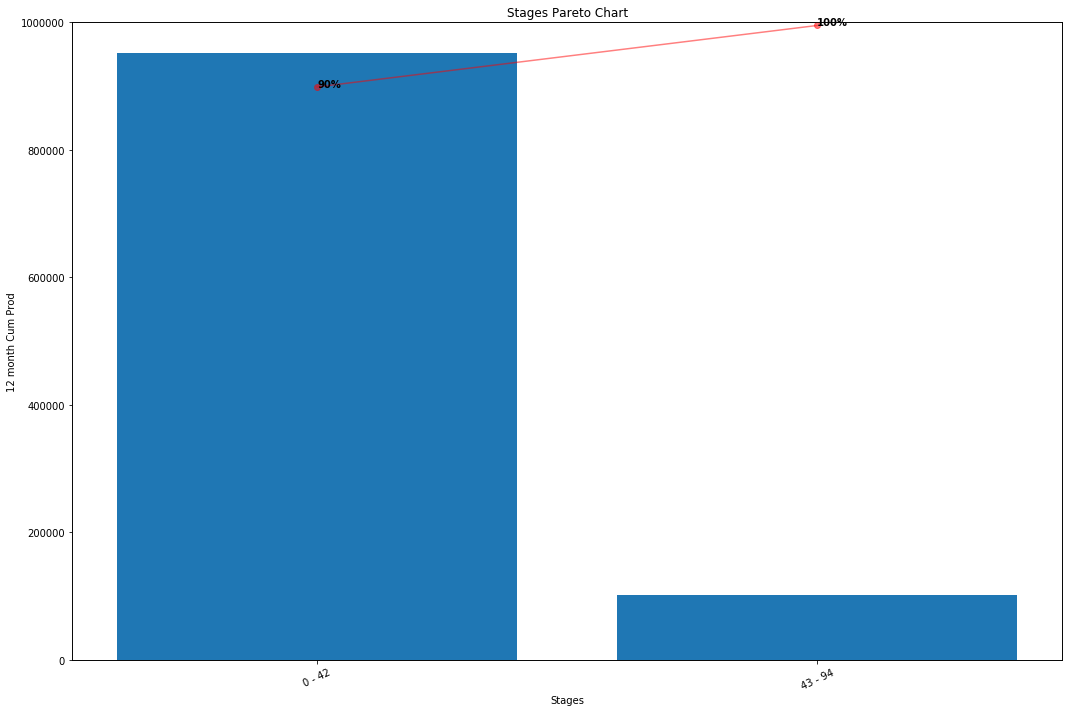

In [30]:
#Calculate cumulative oil production produced depending on the number of stages
Stages_unsorted = DatabaseDF.groupby('Stage Bins')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
Stages = Stages_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Stage Numbers versus Cumulative Production
pareto_plot(x = Stages.index , counts = Stages.values, xlabel = 'Stages', ylabel = '12 month Cum Prod')

## Imputed Data

In [32]:
#Stage Numbers
stage_numbers = []
for i in MICE_DF['Stages'].unique():
    stage_numbers.append(i)

In [33]:
#Find head-tail break value for stage numbers
htb(stage_numbers)

[28.609928648696883, 49.25549405711213]

In [34]:
#Create bins based on head-tail break algorithm
bins = (0, 28.609928648696883, 49.25549405711213, 94)
groupnames = ['0 - 29', '30 - 50', '51 - 94']
MICE_DF['Stage Bins'] = pd.cut(MICE_DF['Stages'], bins = bins, labels = groupnames)

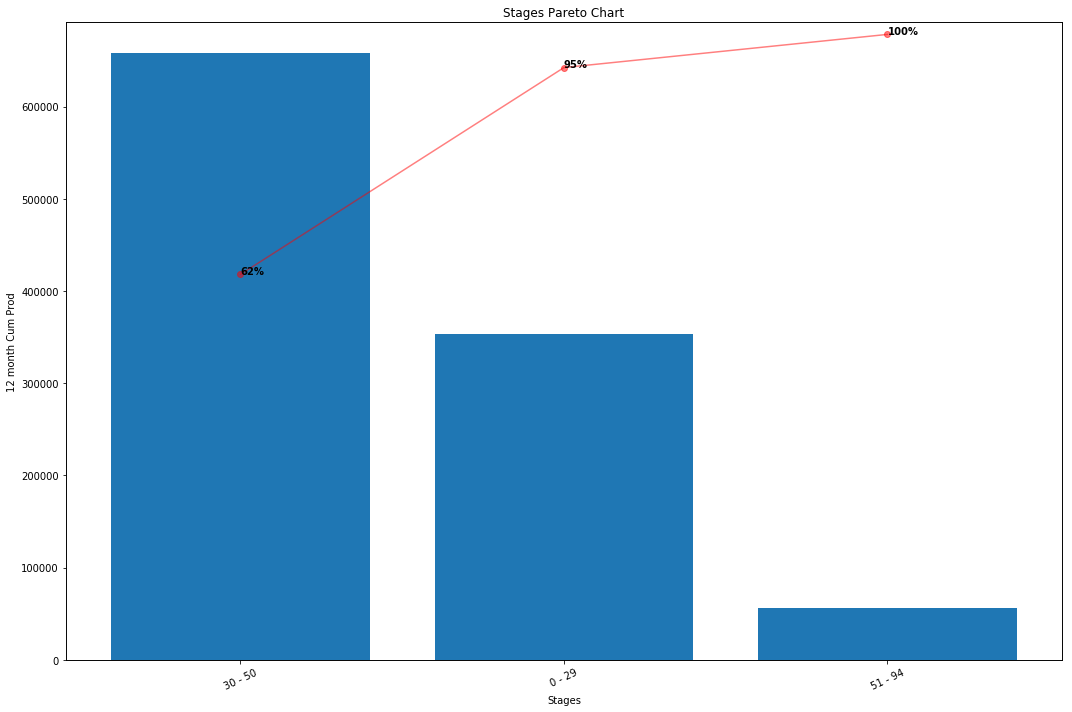

In [35]:
#Calculate cumulative oil production produced depending on the number of stages
Stages_unsorted = MICE_DF.groupby('Stage Bins')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
Stages = Stages_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Stage Numbers versus Cumulative Production
pareto_plot(x = Stages.index , counts = Stages.values, xlabel = 'Stages', ylabel = '12 month Cum Prod')

Before incorporating the imputated data, the Pareto Chart shows that 90% of oil production is associated with stage numbers 0 to 42. After plotting the imputated data, the analysis is slightly more accurate. Stage numbers 30-50 are associated with 62% of the oil production while stage numbers 0 to 29 are associated with 33% of the production.

# Plotting Year Drilled vs Cumulative Oil Production

## Cleaned Data

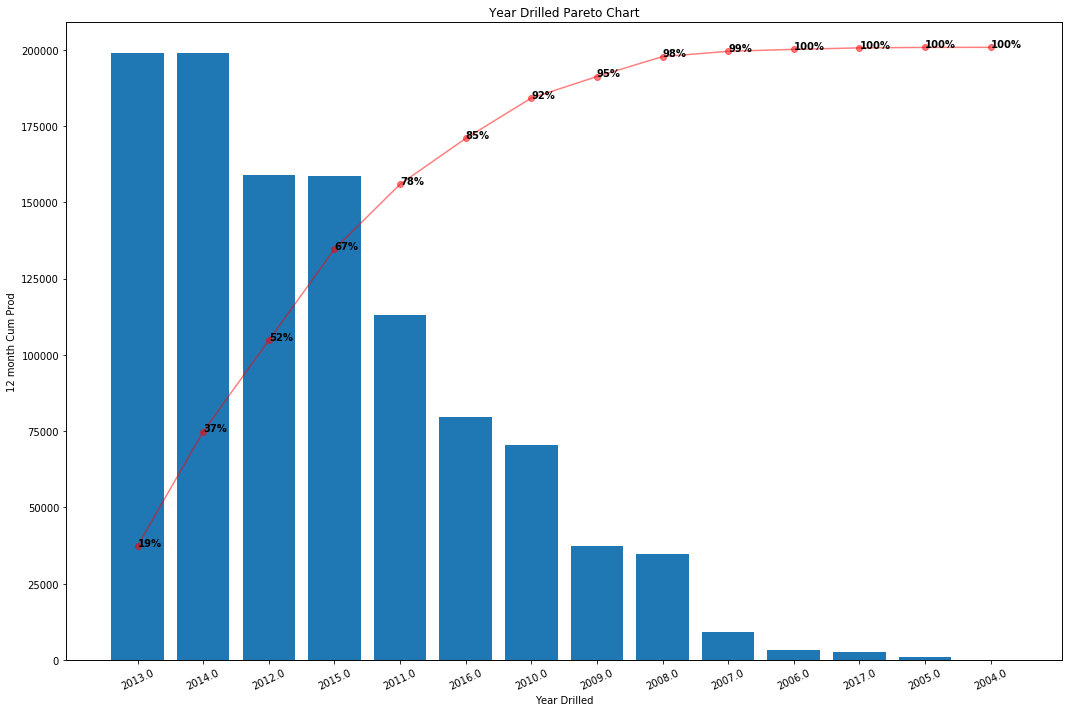

In [36]:
#Calculate cumulative oil production for each Year Drilled
YearProd_unsorted = DatabaseDF.groupby('Year Drilled')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
YearProd = YearProd_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Year Drilled versus Cumulative Production
pareto_plot(x = YearProd.index , counts = YearProd.values, xlabel = 'Year Drilled', ylabel = '12 month Cum Prod')

## Imputed Data

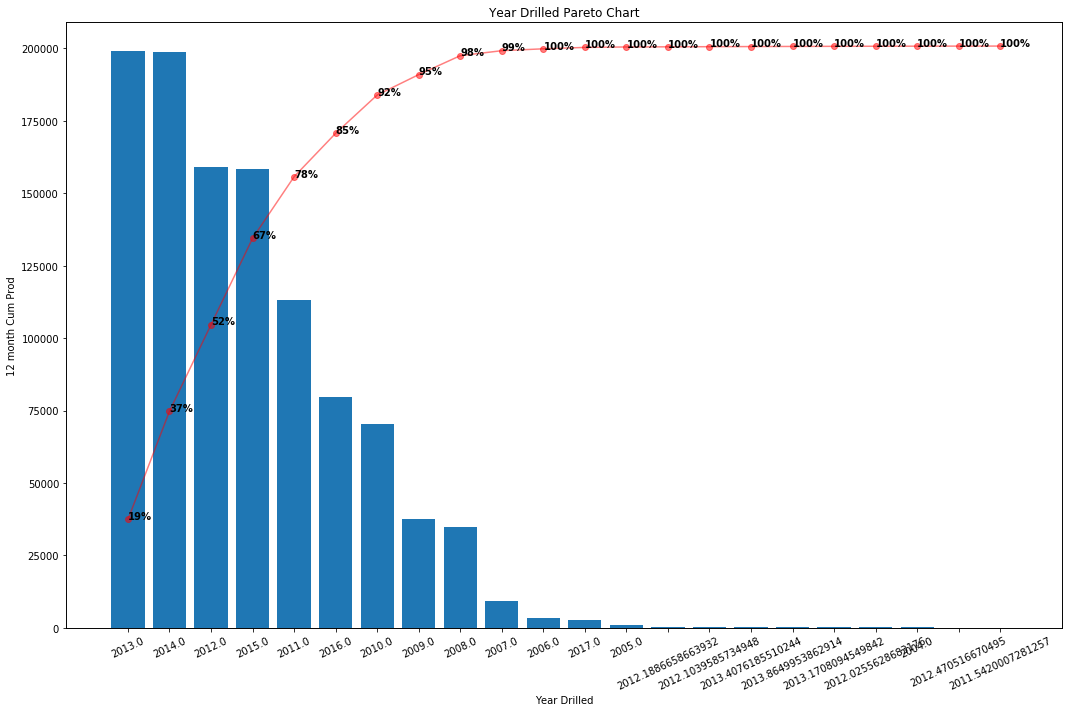

In [37]:
#Calculate cumulative oil production for each Year Drilled
YearProd_unsorted = MICE_DF.groupby('Year Drilled')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
YearProd = YearProd_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Year Drilled versus Cumulative Production
pareto_plot(x = YearProd.index , counts = YearProd.values, xlabel = 'Year Drilled', ylabel = '12 month Cum Prod')

As shown in the chart, the differences between the years are not extremely high. However the highest producing years are 2013 and 2014.As shown in the chart, the differences between the years are not extremely high. However the highest producing years are 2013 and 2014.

# Plotting Total Proppant versus Oil Production

## Cleaned and Imputed Data

In [39]:
#Create 4 bins 
bins = (0, 7186141.75, 14372283.5, 21558425.25, 28744567.0)
groupnames = ['0 - 7.2M lbs', '7.2M - 14.4M lbs', '14.4M - 21.6M', '21.6M - 28.8M']
DatabaseDF['Proppant Bins'] = pd.cut(DatabaseDF['Total Prop, lbs'], bins = bins, labels = groupnames)

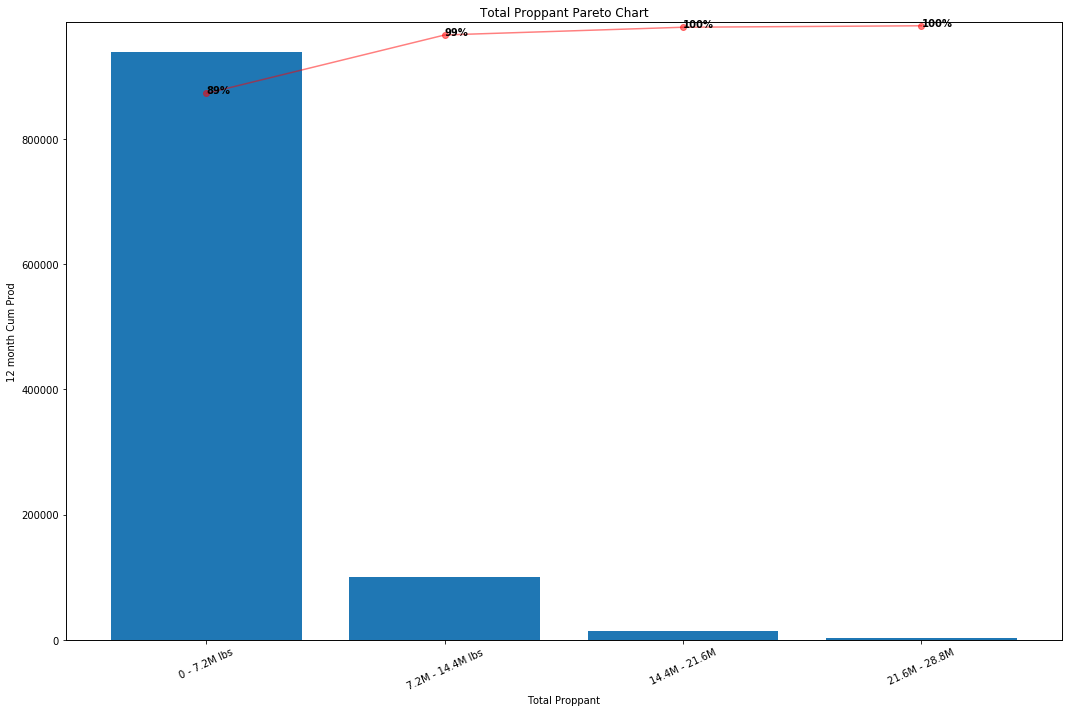

In [41]:
#Calculate cumulative oil production for each Proppant interval
TotalProp_unsorted = DatabaseDF.groupby('Proppant Bins')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
TotalProp = TotalProp_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Total Proppant versus Cumulative Production
pareto_plot(x = TotalProp.index , counts = TotalProp.values, xlabel = 'Total Proppant', ylabel = '12 month Cum Prod')

The Cleaned and Imputed Data produced the same chart, which shows that the interval 0 to around 7.2 million pounds of Proppant are associated with a higher oil production.

# Plotting Amount of Fluid versus Oil Production

## Cleaned Data and Imputed Data 

In [43]:
#Create 4 bins 
bins = (0, 149640.5, 299281.0, 448921.5 , 598562.0)
groupnames = ['0 - 150K bbls', '150K bbls - 300K bbls', '300K bbls - 450K bbls', '450K bbls- 600K bbls']
DatabaseDF['Fluid Bins'] = pd.cut(DatabaseDF['Fluid, bbls'], bins = bins, labels = groupnames)

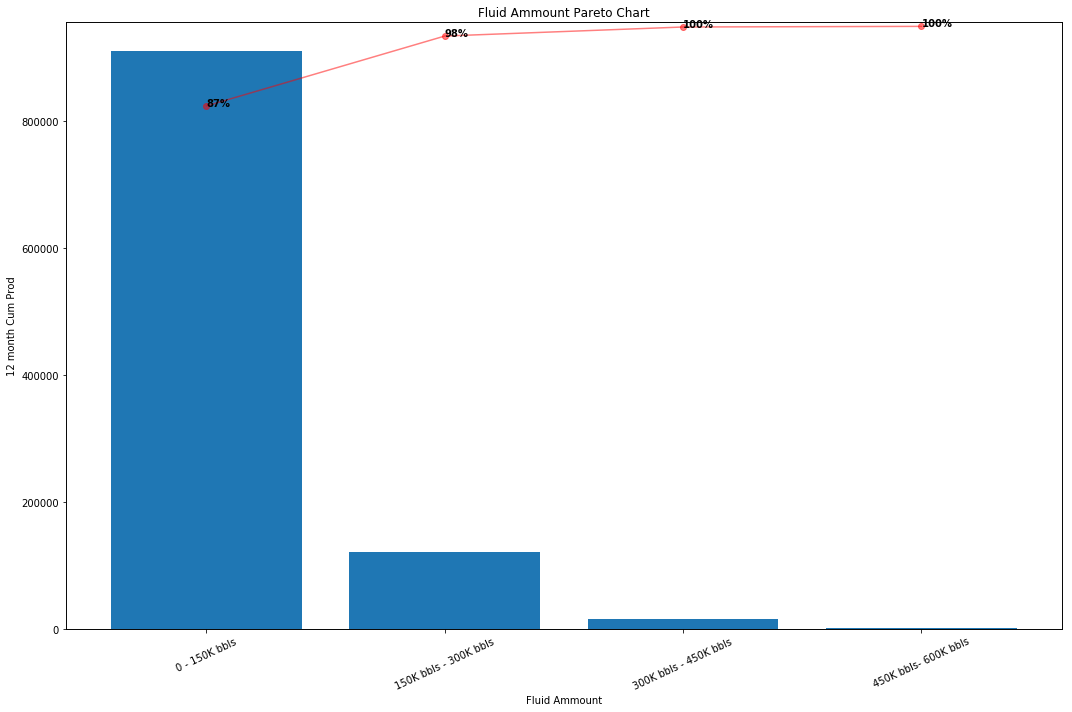

In [46]:
#Calculate cumulative oil production for each Fluid interval
FluidAmount_unsorted = DatabaseDF.groupby('Fluid Bins')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
FluidAmount = FluidAmount_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Fluid versus Cumulative Production
pareto_plot(x = FluidAmount.index , counts = FluidAmount.values, xlabel = 'Fluid Ammount', ylabel = '12 month Cum Prod')

The Cleaned and Imputed Dataset produced the same values and chart, which shows that the interval from 0 to 150 thousand barrels is associated with a higher oil production.

# Plotting Spacing Capped versus Oil Production

## Cleaned Data

In [50]:
#Create 4 bins 
bins = (18.074815, 178.55611125, 339.0374, 499.51870375, 660.0)
groupnames = ['18 - 178.6', '178.6 - 339.0', '339.0 - 500.0', '500.0 - 660.0']
DatabaseDF['Spacing Bins'] = pd.cut(DatabaseDF['SPACING_CAPPED'], bins = bins, labels = groupnames)

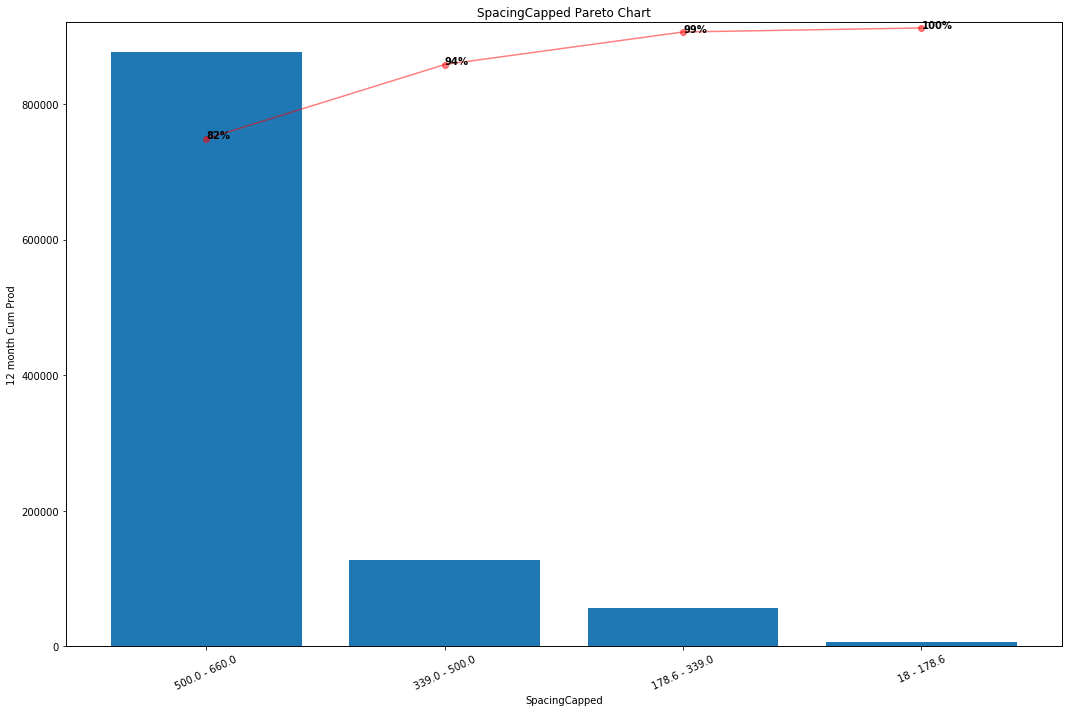

In [51]:
#Calculate cumulative oil production for each Spacing Capped Interval
SpacingCapped_unsorted = DatabaseDF.groupby('Spacing Bins')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
SpacingCapped = SpacingCapped_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Spacing Capped versus Cumulative Production
pareto_plot(x = SpacingCapped.index , counts = SpacingCapped.values, xlabel = 'SpacingCapped', ylabel = '12 month Cum Prod')

## Imputed Data

In [53]:
#Create 4 bins 
bins = (18.074815, 193.67426245784378, 369.27370991568756, 544.8731573735313, 720.4726048313751)
groupnames = ['18.1 - 193.7', '193.7 - 369.3', '369.3 - 544.9', '544.9 - 720.5']
MICE_DF['Spacing Bins'] = pd.cut(MICE_DF['SPACING_CAPPED'], bins = bins, labels = groupnames)

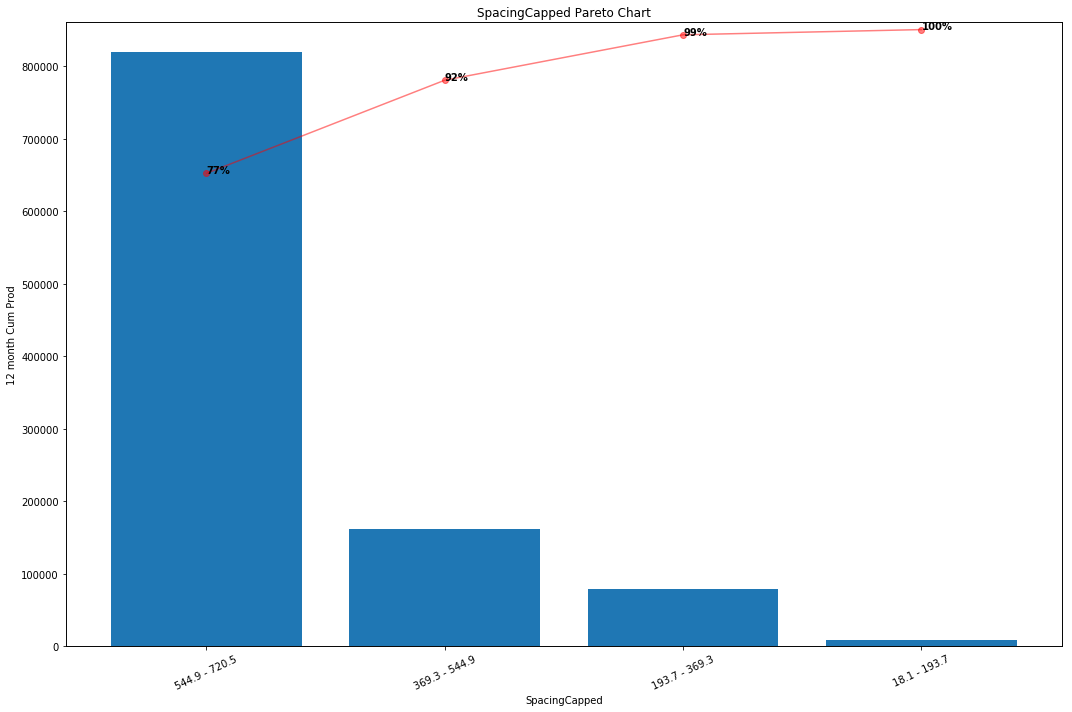

In [55]:
#Calculate cumulative oil production for each Spacing Capped Interval
SpacingCapped_unsorted = MICE_DF.groupby('Spacing Bins')['12 month Cum Prod'].sum()

#Sort chart from highest producing element to least producing element
SpacingCapped = SpacingCapped_unsorted.sort_values(ascending = False)

#Plot Pareto Chart of Spacing Capped versus Cumulative Production
pareto_plot(x = SpacingCapped.index , counts = SpacingCapped.values, xlabel = 'SpacingCapped', ylabel = '12 month Cum Prod')

When the Imputed Data was plotted, the percentages for each interval changed significantly. However, the interval of the largest number spacing capped still remained the interval with the highest oil production.

# Calculating the Confidence Interval for each feature

In [57]:
#Calculate 95% confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

#Structure: (mean value, lower limit, upper limit)

In [58]:
#Returns 95% confidence interval of oil production list 
def categ_oilprod(feature_list, feature_name, df_name):
    unique_array = []
    count = 0
    oil_production = 0
    #Calculate number rows in dataframe
    num_rows = len(df_name.index) 
    for i in feature_list:
        for item in range(num_rows - 1):
            if df_name.at[item, feature_name] == i:
                count += 1
                unique_array.append(df_name.at[item,'12 month Cum Prod'])
        return mean_confidence_interval(unique_array)  

In [59]:
#Lists that will store the feature names and variance values for cleaned data
variance_oilprod = []
features_oilprod = []

#Lists that will store the feature names and variance values for imputed data
variance_imputed = []
features_imputed = []

In [60]:
#Prints Confidence Interval and Variance value for Cleaned Dataset 
def print_results_oilprod(feature_list, feature_name):
    print('Cleaned Dataset:')
    print()
    print(feature_name, "CI: ", categ_oilprod(feature_list, feature_name, DatabaseDF))
    variance = categ_oilprod(feature_list, feature_name, DatabaseDF)[0] - categ_oilprod(feature_list, feature_name, DatabaseDF)[1]
    print("Variance", ": ", variance)
    variance_oilprod.append(variance)
    features_oilprod.append(feature_name)

In [61]:
#Prints Confidence Interval and Variance value for Imputed Dataset 
def print_impute_oilprod(feature_list, feature_name):
    print('Imputed Dataset:')
    print()
    print(feature_name, "CI: ", categ_oilprod(feature_list, feature_name, ImputedDS))
    variance = categ_oilprod(feature_list, feature_name, ImputedDS)[0] - categ_oilprod(feature_list, feature_name, ImputedDS)[1]
    print("Variance", ": ", variance)
    variance_imputed.append(variance)
    features_imputed.append(feature_name)

In [62]:
#Prints final results for both Cleaned and Imputed data 
def print_final_results(feature_list, feature_name):
    print_results_oilprod(feature_list, feature_name)
    print()
    print_impute_oilprod(feature_list, feature_name)

In [63]:
#Prints Formation results
formation_types = ['MBH', 'TFH', 'MBH/TFH', 'TF2', 'TF4','TF3','UTFH','TF1','MTFH','TFSH','TF2.5']
print_final_results(formation_types, 'Formation')

Cleaned Dataset:

Formation CI:  (101.8378227633069, 100.53585707763811, 103.1397884489757)
Variance :  1.3019656856687902

Imputed Dataset:

Formation CI:  (101.91158088235294, 100.60913960795, 103.21402215675587)
Variance :  1.3024412744029377


In [64]:
#Prints Completion Type results
completion_types = ['OH', 'Sleeves', 'P & P', 'Sleeves and P & P', 'Screen',
       'Cemented Liner', 'Perforated Liner', 'Frac Ports',
       'Frac Ports and P & P', 'Frac Ports and Repeater Ports', 'CT',
       'P & P and CT', 'Repeater Ports and P & P']
print_final_results(completion_types, 'Completion Type')

Cleaned Dataset:

Completion Type CI:  (69.74673944687045, 66.93653226872469, 72.55694662501621)
Variance :  2.8102071781457596

Imputed Dataset:

Completion Type CI:  (69.74673944687045, 66.93653226872469, 72.55694662501621)
Variance :  2.8102071781457596


In [65]:
#Prints Fluid Type results
fluid_types = ['LINEAR GEL (HC)', 'CROSSLINKED (HC)', 'SLICKWATER (HC)',
       'SW-XL HYBRID', 'CROSSLINKED', 'UNKNOWN', 'SW-GEL HYBRID',
       'LINEAR GEL']
print_final_results(fluid_types, 'Fluid Type from DI')

Cleaned Dataset:

Fluid Type from DI CI:  (107.7898696596669, 104.85803363120016, 110.72170568813365)
Variance :  2.9318360284667477

Imputed Dataset:

Fluid Type from DI CI:  (107.07940544412608, 104.15204188242764, 110.00676900582452)
Variance :  2.927363561698442


In [66]:
#Prints Year Drilled results
year_drilled = [2006., 2005., 2007., 2008., 2004., 2009., 2011., 2012., 2010.,
       2013., 2014., 2016., 2015., 2017.]
print_final_results(year_drilled, 'Year Drilled')

Cleaned Dataset:

Year Drilled CI:  (44.029487179487184, 33.55511512321959, 54.503859235754774)
Variance :  10.47437205626759

Imputed Dataset:

Year Drilled CI:  (44.029487179487184, 33.55511512321959, 54.503859235754774)
Variance :  10.47437205626759


In [67]:
#Calculates oil production value for an interval/bin for quantitative data
def bins_oilprod(feature_name, min, max, df_name):
    count = 0
    oil_production = 0
    #Calculate number rows in dataframe
    num_rows = len(df_name.index) 
    for item in range(num_rows - 1):
        if df_name.at[item, feature_name] >= min and df_name.at[item, feature_name] <= max:
            count += 1
            oil_production += df_name.at[item,'12 month Cum Prod']
    return oil_production

In [68]:
#Returns 95% confidence interval of oil production list for Cleaned Data
def bins_CI(feature_list, feature_name, df_name):
    oilprod = []
    i = 0
    while i < len(feature_list) - 1:
        oilprod.append(bins_oilprod(feature_name, feature_list[i], feature_list[i+1], df_name))
        i += 1
    return mean_confidence_interval(oilprod)

In [69]:
#Returns 95% confidence interval of oil production list for Imputed Data
def imp_bins_CI(feature_list, feature_name, df_name):
    oilprod = []
    #for i in feature_list:
    i = 0
    while i < len(feature_list) - 1:
        oilprod.append(bins_oilprod(feature_name, feature_list[i], feature_list[i+1], df_name))
        i += 1
    return mean_confidence_interval(oilprod)

In [70]:
#Prints Confidence Interval and Variance value for Cleaned Dataset 
def print_bins_oilprod(feature_list, feature_name, df_name):
    print('Cleaned Dataset:')
    print()
    print(feature_name, "CI: ", bins_CI(feature_list, feature_name, df_name))
    variance = bins_CI(feature_list, feature_name, df_name)[0] - bins_CI(feature_list, feature_name, df_name)[1]
    print("Variance", ": ", variance)
    variance_oilprod.append(variance)
    features_oilprod.append(feature_name)

In [71]:
#Prints Confidence Interval and Variance value for Imputed Dataset 
def print_impute_oilprod(feature_list, feature_name, df_name):
    print('Imputed Dataset:')
    print()
    print(feature_name, "CI: ", imp_bins_CI(feature_list, feature_name, df_name))
    variance = imp_bins_CI(feature_list, feature_name, df_name)[0] - imp_bins_CI(feature_list, feature_name, df_name)[1]
    print("Variance", ": ", variance)
    variance_imputed.append(variance)
    features_imputed.append(feature_name)

In [72]:
#Prints final results for both Cleaned and Imputed data 
def print_bins_results(feature_list1, feature_list2, feature_name):
    print_bins_oilprod(feature_list1, feature_name, DatabaseDF)
    print()
    print_impute_oilprod(feature_list2, feature_name, MICE_DF)

In [73]:
#Prints Stage Number results
stages_bins1 = [0, 42.792682926829265, 94]
stages_bins2 = [0, 28.609928648696883, 49.25549405711213, 94]
print_bins_results(stages_bins1, stages_bins2, 'Stages')

Cleaned Dataset:

Stages CI:  (526991.6699999982, -4872634.426491168, 5926617.766491164)
Variance :  5399626.096491166

Imputed Dataset:

Stages CI:  (356062.3299999998, -391221.9088604188, 1103346.5688604184)
Variance :  747284.2388604186


In [74]:
#Prints Total Proppant results
proppant_bins = [0, 7186141.75, 14372283.5, 21558425.25, 28744567.0]
print_bins_results(proppant_bins, proppant_bins, 'Total Prop, lbs')

Cleaned Dataset:

Total Prop, lbs CI:  (267075.362499999, -463162.62286232854, 997313.3478623265)
Variance :  730237.9853623275

Imputed Dataset:

Total Prop, lbs CI:  (267075.362499999, -463162.62286232854, 997313.3478623265)
Variance :  730237.9853623275


In [75]:
#Prints Fluid results
fluid_bins = [0, 149640.5, 299281.0, 448921.5 , 598562.0]
print_bins_results(fluid_bins, fluid_bins, 'Fluid, bbls')

Cleaned Dataset:

Fluid, bbls CI:  (266348.6349999993, -439875.4721242512, 972572.7421242498)
Variance :  706224.1071242505

Imputed Dataset:

Fluid, bbls CI:  (267075.36249999935, -441287.3320652647, 975438.0570652634)
Variance :  708362.694565264


In [76]:
#Prints Spacing Capped results
spacing_bins1 = [18.074815, 178.55611125, 339.0374, 499.51870375, 660.0]
spacing_bins2 = [18.074815, 193.67426245784378, 369.27370991568756, 544.8731573735313, 720.4726048313751]
print_bins_results(spacing_bins2, spacing_bins2, 'SPACING_CAPPED')

Cleaned Dataset:

SPACING_CAPPED CI:  (266862.86999999936, -326542.6557169988, 860268.3957169976)
Variance :  593405.5257169981

Imputed Dataset:

SPACING_CAPPED CI:  (267075.36249999935, -326996.9460669629, 861147.6710669616)
Variance :  594072.3085669623


## Cleaned Dataset

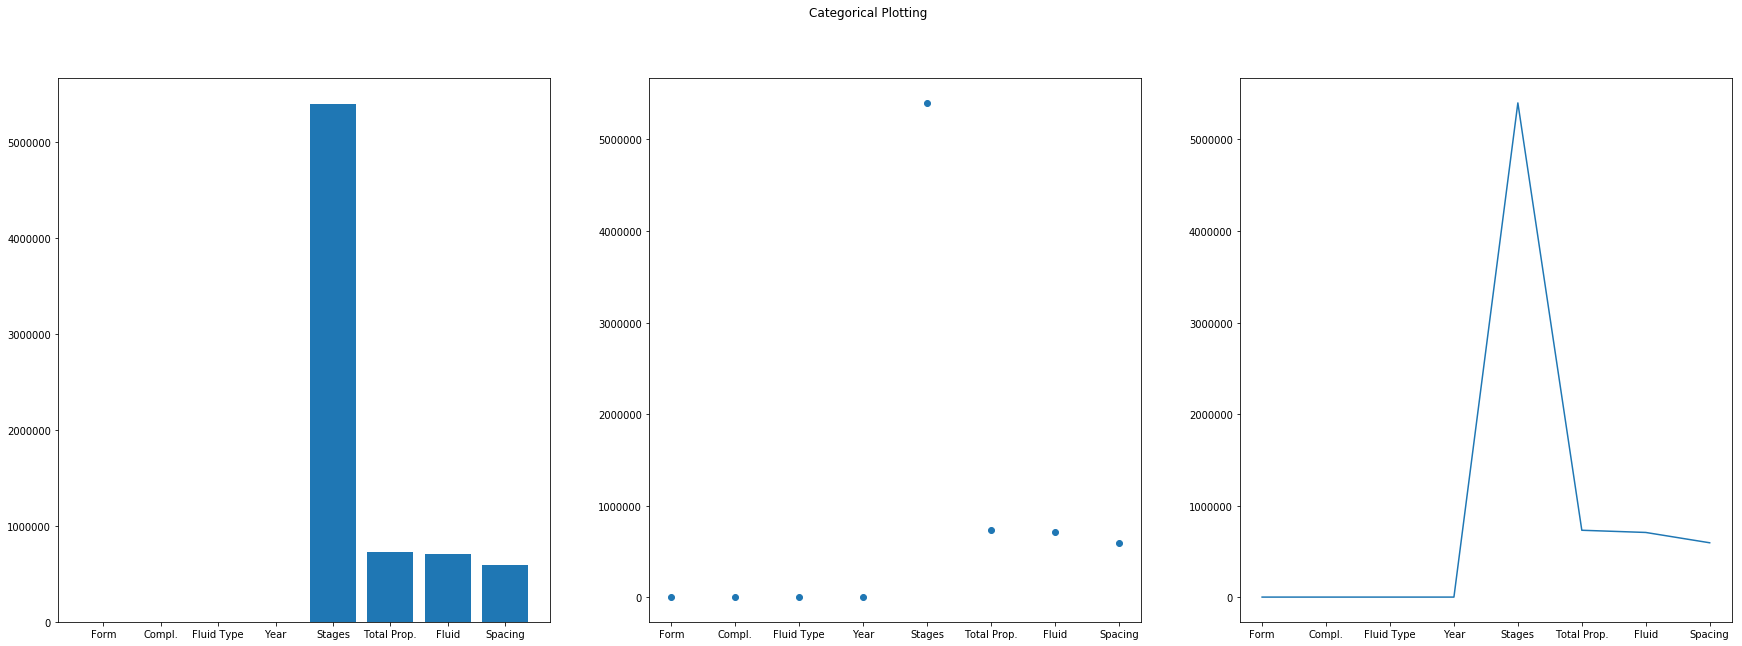

In [78]:
#Prints comparison of variance values for oil production
names = ['Form', 'Compl.', 'Fluid Type', 'Year', 'Stages', 'Total Prop.', 'Fluid', 'Spacing']
values = variance_oilprod
plt.figure(figsize=(30, 10))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()

## Imputed Dataset

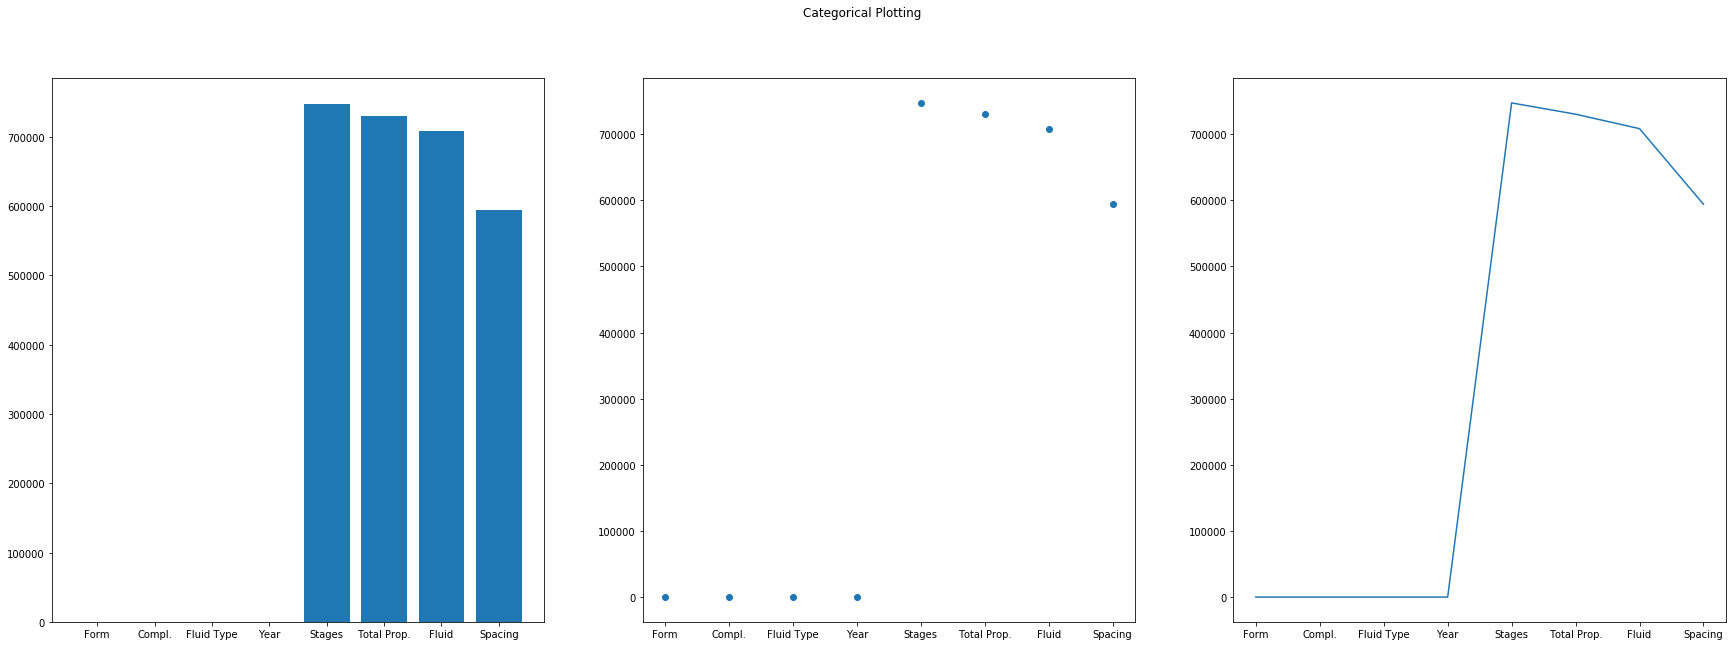

In [79]:
#Prints comparison of variance values for oil production
names = ['Form', 'Compl.', 'Fluid Type', 'Year', 'Stages', 'Total Prop.', 'Fluid', 'Spacing']
values = variance_imputed
plt.figure(figsize=(30, 10))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()